# Testing Alternative Subtraction Hypotheses

**Hypothesis 1: Double Negation**
- Model computes: `(a - b) = -(-(a) + b) = n - ((n - a) + b)`
- More complex: negate a, add b, then negate result
- Could explain why it's not using simple negation of b

**Hypothesis 2: Bitwise/Encoding Trick**  
- Model uses bitwise operations or special encodings
- E.g., learns that certain bit patterns correspond to subtraction
- Would show up as structured patterns in embeddings

**Mathematical Verification:**
```
Double negation:
  -(-(a) + b) mod 113
  = (113 - ((113 - a) + b)) mod 113
  = (113 - 113 + a - b) mod 113  
  = (a - b) mod 113 ✓
```

## Setup

In [8]:
# Mount Google Drive and navigate to repo
from google.colab import drive
import os

drive.mount('/content/drive')

if not os.path.exists('progress-measures-paper-extension'):
    !git clone https://github.com/Junekhunter/progress-measures-paper-extension.git

os.chdir('progress-measures-paper-extension')
!pip install -q einops

print(f"Working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'progress-measures-paper-extension'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 109 (delta 47), reused 63 (delta 26), pack-reused 20 (from 1)
Receiving objects: 100% (109/109), 27.42 MiB | 10.64 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Working directory: /content/progress-measures-paper-extension/progress-measures-paper-extension


In [9]:
# Imports
import sys
sys.path.insert(0, '.')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import replace
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine

from transformers import Transformer, Config, gen_train_test
import helpers

sns.set_style('whitegrid')
print("✓ Imports successful")

✓ Imports successful


In [10]:
# Configuration
EXPERIMENT_DIR = input("Enter experiment directory: ")
SEED = 42
p = 113

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Modulus p: {p}")

Enter experiment directory: /content/drive/MyDrive/grokking_transfer_experiments/3way_run_20251230_101636
Device: cuda
Modulus p: 113


## Load Model

In [11]:
# Load grokked transfer (subtraction) model
print("Loading grokked transfer (subtraction) model...")

config = Config(
    lr=1e-3,
    weight_decay=1.0,
    p=p,
    d_model=128,
    fn_name='subtract',
    frac_train=0.3,
    seed=SEED,
    device=device
)

checkpoint_path = f'{EXPERIMENT_DIR}/checkpoints/grokked_transfer_seed{SEED}.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')

model = Transformer(config, use_cache=False)
model.load_state_dict(checkpoint['model_state'], strict=True)
model.to(device)
model.eval()

print(f"✓ Model loaded")
print(f"  Accuracy: {checkpoint['final_test_accuracy']:.4f}")

Loading grokked transfer (subtraction) model...
✓ Model loaded
  Accuracy: 0.9981


## Hypothesis 1: Double Negation Test

**Test if model computes**: `n - ((n - a) + b) = a - b`

### Three-step process:
1. Negate `a`: compute `(n - a)`
2. Add `b`: compute `(n - a) + b`  
3. Negate result: compute `n - ((n - a) + b) = a - b`

### Tests:
- **Embedding test**: Check if `embed(a) + embed(n-a) ≈ constant` (negation of a)
- **Activation matching**: Compare activations on `(a,b)` vs intermediate steps
- **Intervention**: Patch in `(n-a)` and see what happens

In [12]:
print("="*80)
print("HYPOTHESIS 1: Double Negation")
print("Testing: (a - b) = n - ((n - a) + b)")
print("="*80)

# Get embedding matrix
W_E = model.embed.W_E.data  # [d_model, d_vocab]

print("\n1. Testing if model negates 'a' (first input)")
print("-" * 80)

# Check: does embed(a) + embed(n-a) ≈ constant?
negation_sums_a = []
for a in range(p):
    neg_a = (p - a) % p
    sum_vec = (W_E[:, a] + W_E[:, neg_a]).cpu().numpy()
    negation_sums_a.append(sum_vec)

negation_sums_a = np.array(negation_sums_a)
variance_a = negation_sums_a.var(axis=0).mean()
baseline_var = W_E.T.cpu().numpy().var(axis=0).mean()

reduction_a = variance_a / baseline_var

print(f"Variance of embed(a) + embed(n-a): {variance_a:.6f}")
print(f"Baseline variance: {baseline_var:.6f}")
print(f"Reduction ratio: {reduction_a:.4f}")

if reduction_a < 0.1:
    print("\n✓ STRONG evidence for negation of 'a'!")
    a_negation_evidence = "strong"
elif reduction_a < 0.5:
    print("\n→ MODERATE evidence for negation of 'a'")
    a_negation_evidence = "moderate"
else:
    print("\n✗ NO evidence for negation of 'a'")
    a_negation_evidence = "none"

print("\n2. Testing if model negates 'b' (second input)")
print("-" * 80)

# Check: does embed(b) + embed(n-b) ≈ constant?
negation_sums_b = []
for b in range(p):
    neg_b = (p - b) % p
    sum_vec = (W_E[:, b] + W_E[:, neg_b]).cpu().numpy()
    negation_sums_b.append(sum_vec)

negation_sums_b = np.array(negation_sums_b)
variance_b = negation_sums_b.var(axis=0).mean()
reduction_b = variance_b / baseline_var

print(f"Variance of embed(b) + embed(n-b): {variance_b:.6f}")
print(f"Baseline variance: {baseline_var:.6f}")
print(f"Reduction ratio: {reduction_b:.4f}")

if reduction_b < 0.1:
    print("\n✓ STRONG evidence for negation of 'b'!")
    b_negation_evidence = "strong"
elif reduction_b < 0.5:
    print("\n→ MODERATE evidence for negation of 'b'")
    b_negation_evidence = "moderate"
else:
    print("\n✗ NO evidence for negation of 'b'")
    b_negation_evidence = "none"

print("\n" + "="*80)
print("SUMMARY: Negation Detection")
print("="*80)
print(f"Negates 'a': {a_negation_evidence} (ratio: {reduction_a:.4f})")
print(f"Negates 'b': {b_negation_evidence} (ratio: {reduction_b:.4f})")

if a_negation_evidence in ["strong", "moderate"] and b_negation_evidence == "none":
    print("\n→ DOUBLE NEGATION hypothesis viable!")
    print("  Model may: negate a → add b → negate result")
    double_negation_viable = True
elif b_negation_evidence in ["strong", "moderate"] and a_negation_evidence == "none":
    print("\n→ SIMPLE NEGATION hypothesis viable!")
    print("  Model may: negate b → add a")
    double_negation_viable = False
elif a_negation_evidence in ["strong", "moderate"] and b_negation_evidence in ["strong", "moderate"]:
    print("\n→ BOTH inputs show negation structure!")
    print("  Unexpected - may indicate symmetric encoding")
    double_negation_viable = True
else:
    print("\n→ NO CLEAR negation pattern detected")
    print("  Model may use different algorithm entirely")
    double_negation_viable = False

HYPOTHESIS 1: Double Negation
Testing: (a - b) = n - ((n - a) + b)

1. Testing if model negates 'a' (first input)
--------------------------------------------------------------------------------
Variance of embed(a) + embed(n-a): 0.020691
Baseline variance: 0.010390
Reduction ratio: 1.9914

✗ NO evidence for negation of 'a'

2. Testing if model negates 'b' (second input)
--------------------------------------------------------------------------------
Variance of embed(b) + embed(n-b): 0.020691
Baseline variance: 0.010390
Reduction ratio: 1.9914

✗ NO evidence for negation of 'b'

SUMMARY: Negation Detection
Negates 'a': none (ratio: 1.9914)
Negates 'b': none (ratio: 1.9914)

→ NO CLEAR negation pattern detected
  Model may use different algorithm entirely


✓ Saved: double_negation_test.png


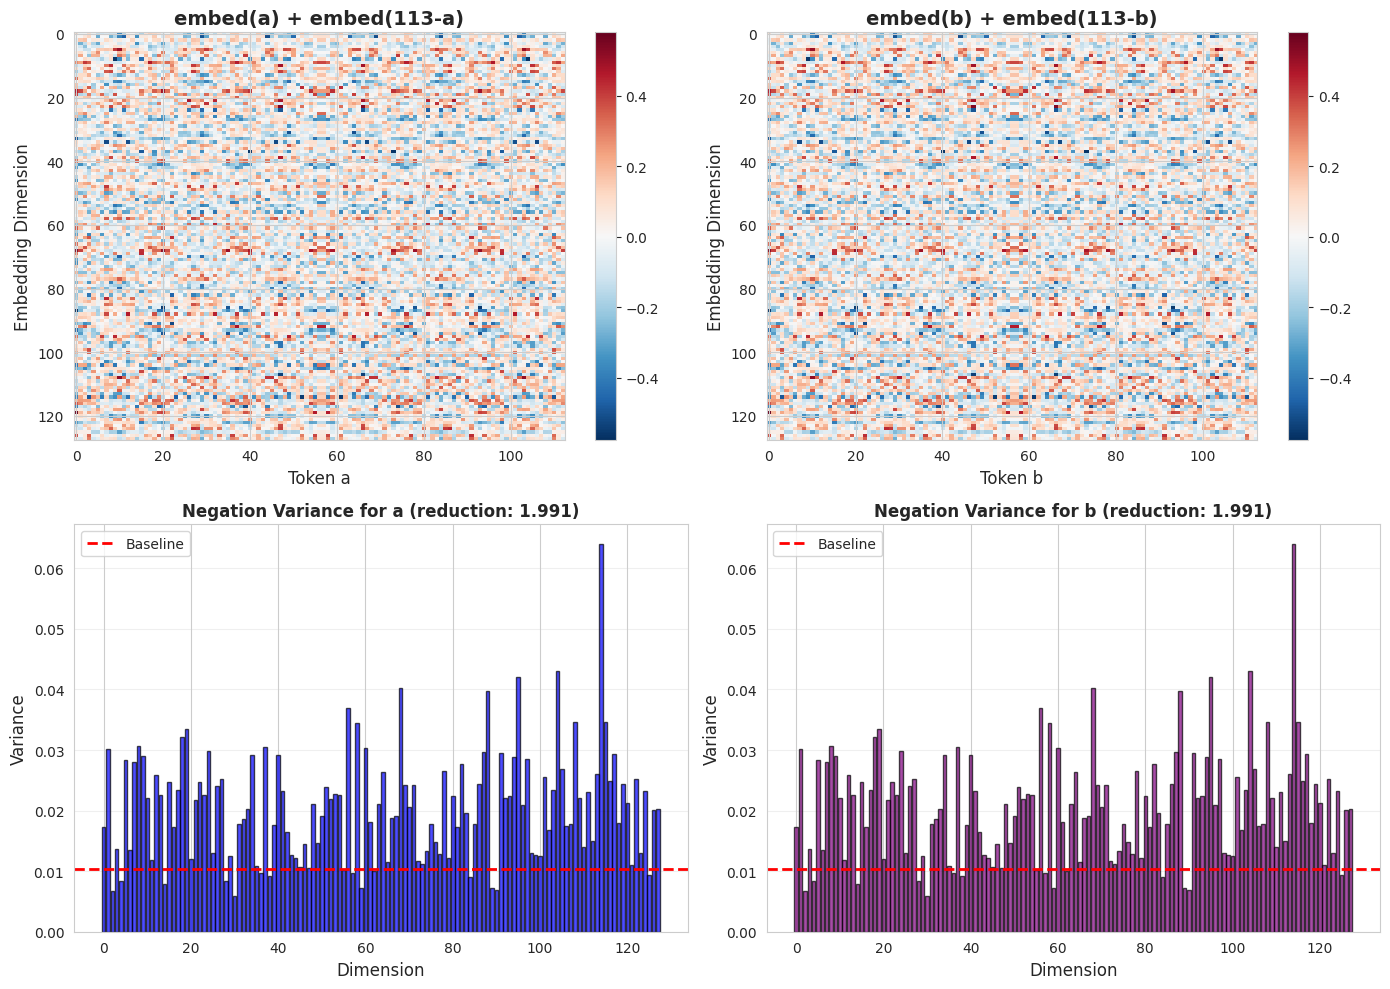

In [13]:
# Visualization: Compare negation structure for a vs b
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: embed(a) + embed(n-a) heatmap
ax = axes[0, 0]
im = ax.imshow(negation_sums_a.T, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('Token a', fontsize=12)
ax.set_ylabel('Embedding Dimension', fontsize=12)
ax.set_title('embed(a) + embed(113-a)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax)

# Plot 2: embed(b) + embed(n-b) heatmap
ax = axes[0, 1]
im = ax.imshow(negation_sums_b.T, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('Token b', fontsize=12)
ax.set_ylabel('Embedding Dimension', fontsize=12)
ax.set_title('embed(b) + embed(113-b)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax)

# Plot 3: Variance per dimension for a
ax = axes[1, 0]
var_per_dim_a = negation_sums_a.var(axis=0)
ax.bar(range(len(var_per_dim_a)), var_per_dim_a, alpha=0.7, color='blue', edgecolor='black')
ax.axhline(baseline_var, color='red', linestyle='--', label='Baseline', linewidth=2)
ax.set_xlabel('Dimension', fontsize=12)
ax.set_ylabel('Variance', fontsize=12)
ax.set_title(f'Negation Variance for a (reduction: {reduction_a:.3f})',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Variance per dimension for b
ax = axes[1, 1]
var_per_dim_b = negation_sums_b.var(axis=0)
ax.bar(range(len(var_per_dim_b)), var_per_dim_b, alpha=0.7, color='purple', edgecolor='black')
ax.axhline(baseline_var, color='red', linestyle='--', label='Baseline', linewidth=2)
ax.set_xlabel('Dimension', fontsize=12)
ax.set_ylabel('Variance', fontsize=12)
ax.set_title(f'Negation Variance for b (reduction: {reduction_b:.3f})',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{EXPERIMENT_DIR}/figures/double_negation_test.png', dpi=200, bbox_inches='tight')
print("✓ Saved: double_negation_test.png")
plt.show()

## Hypothesis 2: Bitwise/Encoding Patterns

**Test for structured encoding patterns:**
- Binary representation correlations
- Clustered embeddings (e.g., even/odd, multiples)
- Distance preservation (metric structure)

In [14]:
print("\n" + "="*80)
print("HYPOTHESIS 2: Bitwise/Encoding Patterns")
print("="*80)

print("\n1. Testing Binary Representation Correlation")
print("-" * 80)

# Convert numbers to binary vectors
num_bits = int(np.ceil(np.log2(p)))
binary_vecs = np.array([[int(b) for b in format(i, f'0{num_bits}b')] for i in range(p)])

print(f"Binary representation: {num_bits} bits for p={p}")

# Get embeddings (only first p tokens, excluding special tokens like "=")
embeddings = W_E[:, :p].T.cpu().numpy()  # [p, d_model]

# For each embedding dimension, compute correlation with each bit
bit_correlations = []
for dim in range(embeddings.shape[1]):
    embed_dim = embeddings[:, dim]

    dim_bit_corrs = []
    for bit in range(num_bits):
        corr = np.abs(pearsonr(embed_dim, binary_vecs[:, bit])[0])
        dim_bit_corrs.append(corr)

    bit_correlations.append(dim_bit_corrs)

bit_correlations = np.array(bit_correlations)  # [d_model, num_bits]
max_bit_corr = bit_correlations.max(axis=1).mean()

print(f"\nMean max bit correlation: {max_bit_corr:.3f}")

if max_bit_corr > 0.7:
    print("✓ STRONG bitwise encoding detected!")
    print("  Embeddings strongly correlated with binary representation")
    bitwise_evidence = "strong"
elif max_bit_corr > 0.4:
    print("→ MODERATE bitwise structure")
    bitwise_evidence = "moderate"
else:
    print("✗ NO significant bitwise encoding")
    bitwise_evidence = "none"

print("\n2. Testing Even/Odd Clustering")
print("-" * 80)

# Compute mean embeddings for even vs odd numbers
even_mask = np.arange(p) % 2 == 0
odd_mask = ~even_mask

mean_even = embeddings[even_mask].mean(axis=0)
mean_odd = embeddings[odd_mask].mean(axis=0)

# Distance between even and odd centroids
even_odd_dist = np.linalg.norm(mean_even - mean_odd)

# Compare to typical distance between random numbers
random_dists = []
for _ in range(100):
    idx1 = np.random.randint(0, p)
    idx2 = np.random.randint(0, p)
    dist = np.linalg.norm(embeddings[idx1] - embeddings[idx2])
    random_dists.append(dist)

mean_random_dist = np.mean(random_dists)
even_odd_ratio = even_odd_dist / mean_random_dist

print(f"Distance between even/odd centroids: {even_odd_dist:.3f}")
print(f"Mean random distance: {mean_random_dist:.3f}")
print(f"Ratio: {even_odd_ratio:.3f}")

if even_odd_ratio > 2.0:
    print("\n✓ STRONG even/odd clustering!")
    clustering_evidence = "strong"
elif even_odd_ratio > 1.3:
    print("\n→ MODERATE even/odd separation")
    clustering_evidence = "moderate"
else:
    print("\n✗ NO significant even/odd clustering")
    clustering_evidence = "none"

print("\n3. Testing Modular Distance Preservation")
print("-" * 80)

# Check if embedding distance correlates with modular distance
mod_dists = []
embed_dists = []

for i in range(p):
    for j in range(i+1, min(i+20, p)):  # Sample nearby pairs
        mod_dist = min((i - j) % p, (j - i) % p)  # Circular distance
        embed_dist = np.linalg.norm(embeddings[i] - embeddings[j])

        mod_dists.append(mod_dist)
        embed_dists.append(embed_dist)

distance_corr = pearsonr(mod_dists, embed_dists)[0]

print(f"Correlation between modular and embedding distance: {distance_corr:.3f}")

if abs(distance_corr) > 0.7:
    print("\n✓ STRONG metric structure!")
    print("  Embeddings preserve modular distance")
    metric_evidence = "strong"
elif abs(distance_corr) > 0.4:
    print("\n→ MODERATE metric structure")
    metric_evidence = "moderate"
else:
    print("\n✗ NO metric structure preservation")
    metric_evidence = "none"


HYPOTHESIS 2: Bitwise/Encoding Patterns

1. Testing Binary Representation Correlation
--------------------------------------------------------------------------------
Binary representation: 7 bits for p=113

Mean max bit correlation: 0.075
✗ NO significant bitwise encoding

2. Testing Even/Odd Clustering
--------------------------------------------------------------------------------
Distance between even/odd centroids: 0.049
Mean random distance: 1.650
Ratio: 0.030

✗ NO significant even/odd clustering

3. Testing Modular Distance Preservation
--------------------------------------------------------------------------------
Correlation between modular and embedding distance: -0.177

✗ NO metric structure preservation


✓ Saved: encoding_patterns.png


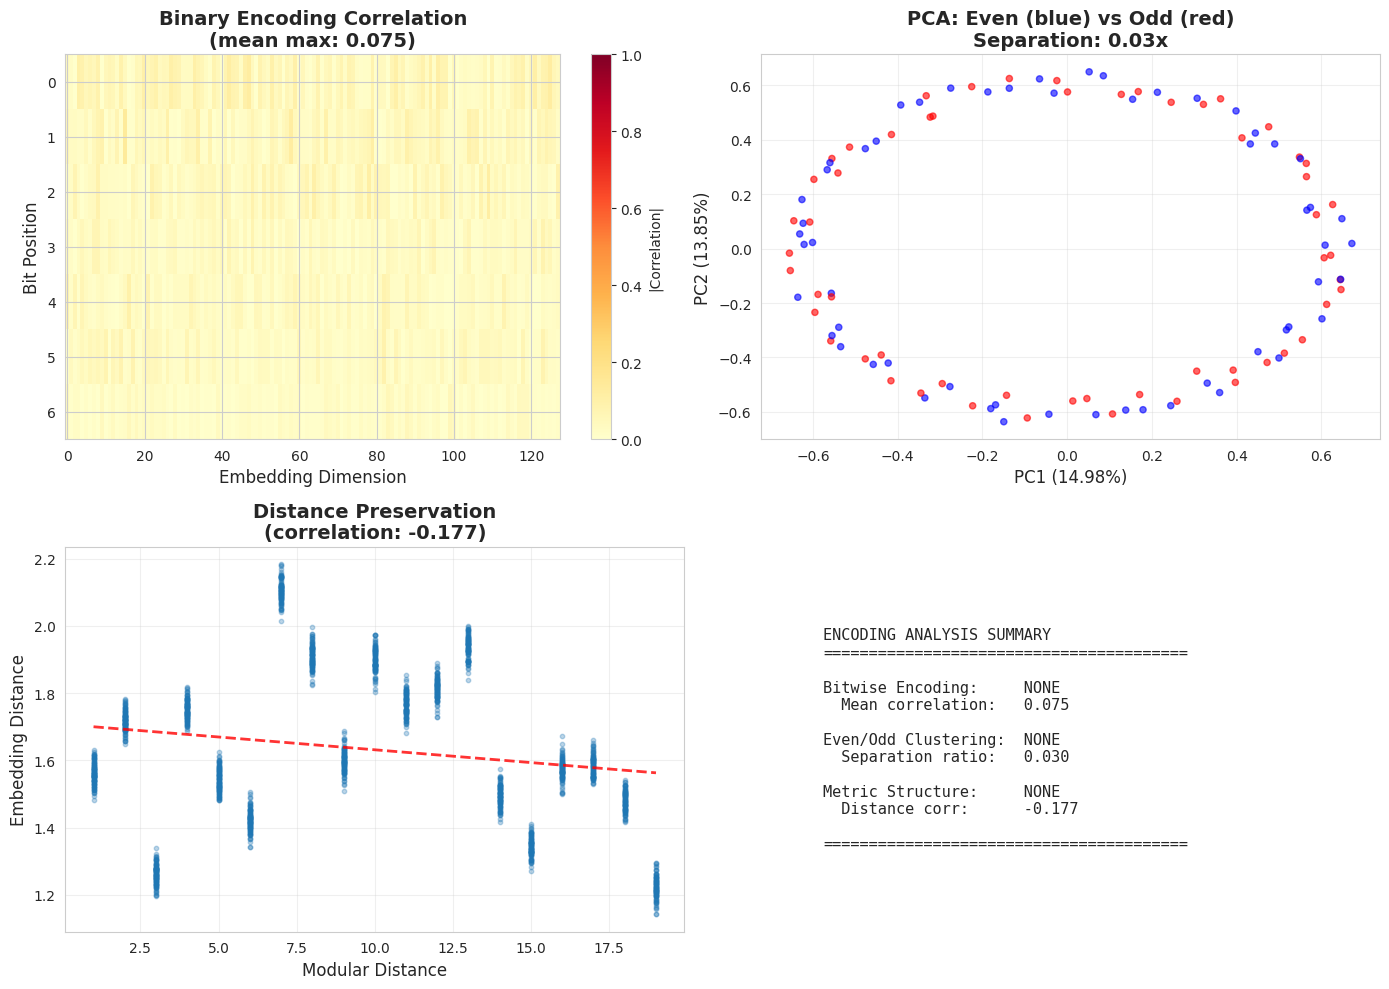

In [15]:
# Visualization: Encoding patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Bit correlation heatmap
ax = axes[0, 0]
im = ax.imshow(bit_correlations.T, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xlabel('Embedding Dimension', fontsize=12)
ax.set_ylabel('Bit Position', fontsize=12)
ax.set_title(f'Binary Encoding Correlation\n(mean max: {max_bit_corr:.3f})',
             fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='|Correlation|')

# Plot 2: PCA of embeddings colored by even/odd
ax = axes[0, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

colors = ['blue' if i % 2 == 0 else 'red' for i in range(p)]
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
ax.set_title(f'PCA: Even (blue) vs Odd (red)\nSeparation: {even_odd_ratio:.2f}x',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Modular distance vs embedding distance
ax = axes[1, 0]
ax.scatter(mod_dists, embed_dists, alpha=0.3, s=10)
ax.set_xlabel('Modular Distance', fontsize=12)
ax.set_ylabel('Embedding Distance', fontsize=12)
ax.set_title(f'Distance Preservation\n(correlation: {distance_corr:.3f})',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add trendline
z = np.polyfit(mod_dists, embed_dists, 1)
p_line = np.poly1d(z)
ax.plot(sorted(mod_dists), p_line(sorted(mod_dists)), "r--", alpha=0.8, linewidth=2)

# Plot 4: Summary table
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""
ENCODING ANALYSIS SUMMARY
{'='*40}

Bitwise Encoding:     {bitwise_evidence.upper()}
  Mean correlation:   {max_bit_corr:.3f}

Even/Odd Clustering:  {clustering_evidence.upper()}
  Separation ratio:   {even_odd_ratio:.3f}

Metric Structure:     {metric_evidence.upper()}
  Distance corr:      {distance_corr:.3f}

{'='*40}
"""

ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
        verticalalignment='center')

plt.tight_layout()
plt.savefig(f'{EXPERIMENT_DIR}/figures/encoding_patterns.png', dpi=200, bbox_inches='tight')
print("✓ Saved: encoding_patterns.png")
plt.show()

## Final Summary: Which Hypothesis is Supported?

In [16]:
print("\n" + "="*80)
print("COMPREHENSIVE HYPOTHESIS SUMMARY")
print("="*80)

print("\n" + "="*80)
print("HYPOTHESIS 1: Double Negation - (a - b) = n - ((n - a) + b)")
print("="*80)
print(f"Evidence for negating 'a': {a_negation_evidence.upper()} (ratio: {reduction_a:.4f})")
print(f"Evidence for negating 'b': {b_negation_evidence.upper()} (ratio: {reduction_b:.4f})")

if double_negation_viable:
    print("\n✓ DOUBLE NEGATION is VIABLE")
    print("  Model shows negation structure in embeddings")
    if a_negation_evidence in ["strong", "moderate"]:
        print("  → Suggests: negate(a) → add b → negate result")
else:
    print("\n✗ DOUBLE NEGATION not strongly supported")

print("\n" + "="*80)
print("HYPOTHESIS 2: Bitwise/Encoding Patterns")
print("="*80)
print(f"Bitwise encoding:     {bitwise_evidence.upper()} ({max_bit_corr:.3f})")
print(f"Even/odd clustering:  {clustering_evidence.upper()} ({even_odd_ratio:.3f}x)")
print(f"Metric preservation:  {metric_evidence.upper()} (r={distance_corr:.3f})")

encoding_score = sum([bitwise_evidence != "none",
                     clustering_evidence != "none",
                     metric_evidence != "none"])

if encoding_score >= 2:
    print("\n✓ STRUCTURED ENCODING detected")
    print("  Model uses special encoding properties")
elif encoding_score == 1:
    print("\n→ SOME encoding structure present")
else:
    print("\n✗ NO special encoding detected")
    print("  Embeddings appear learned, not structured")

print("\n" + "="*80)
print("OVERALL CONCLUSION")
print("="*80)

# Rank hypotheses
hypotheses_ranked = []

if b_negation_evidence in ["strong", "moderate"]:
    hypotheses_ranked.append(("Simple negation: (a + (n-b))", b_negation_evidence))

if double_negation_viable:
    hypotheses_ranked.append(("Double negation: n - ((n-a) + b)", a_negation_evidence))

if encoding_score >= 2:
    hypotheses_ranked.append(("Structured encoding", "strong" if encoding_score == 3 else "moderate"))

if hypotheses_ranked:
    print("\nMost likely mechanisms (ranked):")
    for i, (hyp, strength) in enumerate(hypotheses_ranked, 1):
        print(f"{i}. {hyp} ({strength})")
else:
    print("\n→ NO clear mechanism detected")
    print("  Model may use a novel algorithm not tested here")
    print("  Recommend: Direct intervention experiments or logit lens")

print("\n" + "="*80)


COMPREHENSIVE HYPOTHESIS SUMMARY

HYPOTHESIS 1: Double Negation - (a - b) = n - ((n - a) + b)
Evidence for negating 'a': NONE (ratio: 1.9914)
Evidence for negating 'b': NONE (ratio: 1.9914)

✗ DOUBLE NEGATION not strongly supported

HYPOTHESIS 2: Bitwise/Encoding Patterns
Bitwise encoding:     NONE (0.075)
Even/odd clustering:  NONE (0.030x)
Metric preservation:  NONE (r=-0.177)

✗ NO special encoding detected
  Embeddings appear learned, not structured

OVERALL CONCLUSION

→ NO clear mechanism detected
  Model may use a novel algorithm not tested here
  Recommend: Direct intervention experiments or logit lens

